In [2]:
#%matplotlib inline
%matplotlib notebook
from astropy.cosmology import LambdaCDM
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
import astropy.units as u
from scipy.integrate import quad
import ezgal # BC03 model maker
import os

# Setup Cosmology

In [3]:
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7, Tcmb0=2.725)

# Create Stellar Population

In [4]:
# check to make sure we have defined the bpz filter path
if not os.getenv('EZGAL_FILTERS'):
    os.environ['EZGAL_FILTERS'] = (f'{os.environ["HOME"]}/Projects/planckClusters/MOSAICpipe/bpz-1.99.3/FILTER/')

model = ezgal.model('bc03_ssp_z_0.02_salp.model')
model = model.make_exponential(1)
model.set_cosmology(Om=cosmo.Om0, Ol=cosmo.Ode0, h=cosmo.h, w=cosmo.w(0))
                                   
model.add_filter('g_MOSAICII.res', name='g')
model.add_filter('r_MOSAICII.res', name='r')
model.add_filter('i_MOSAICII.res', name='i')
model.add_filter('z_MOSAICII.res', name='z')
model.add_filter('K_KittPeak.res', name='K')

# Blanton 2003 Normalization
Mr_star = -20.44 + 5 * np.log10(cosmo.h) # abs mag.
# set the normalization
model.set_normalization('sloan_r', 0.1, Mr_star, vega=False)                                   

/home/boada/.local/lib/python3.6/site-packages/ezgal/data/models/bc03_ssp_z_0.02_salp.model


/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:358: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:360: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:361: RuntimeWarning: invalid value encountered in add
  y[slice2]*(2-h0divh1))


# Calculate a few things to get going.

In [5]:
# desired formation redshift
zf = 6.0
# fetch an array of redshifts out to given formation redshift
zs = model.get_zs(zf)

# Calculate some cosmological stuff
DM = cosmo.distmod(zs)
dlum = cosmo.luminosity_distance(zs)

# Define the functions that we'll need

Need to compute the cluster volume...

$M_{vir} = 4/3 \pi r^3_{vir} \rho_c(r<r_{vir}) = 4/3 \pi r^3_{vir} \Delta_c \rho_c$

if we let $\Delta_c = 200$ then 

$M_{200} = 4/3 \pi r^3_{200} 200 \rho_c$ with $\rho_c = \frac{3H(z)^2}{8\pi G}$

or just $M_{200} = V_{200}200\rho_c$. So we'll make a function to calculate $\rho_c$. And we'll make use of the astropy units package to do all the unit analysis for us.

Don't forget that $H(z) = H_0E(z)$ 

## We also need to integrate the Schechter luminosity functions..

The Schechter Function:

For Luminosity:

$\Phi(L) = \phi^\star \frac{L}{L_\star}^\alpha e^{-\frac{L}{L_\star}}$

For Magnitudes:

$\Phi(M) = \phi^\star\frac{2}{5}log(10) (10^{\frac{2}{5}(M_\star - M)})^{\alpha+1} e^{-10^{\frac{2}{5}(M_\star - M)}}$




In [6]:
def rho_crit(z, cosmo):
    # convert G into better units:
    G = const.G.to(u.km**2 * u.Mpc/(u.M_sun * u.s**2))
    return 3 / (8 * np.pi * G) * cosmo.H0**2 * cosmo.efunc(z)**2 # Mpc^3

def schechterL(luminosity, phiStar, alpha, LStar): 
    """Schechter luminosity function.""" 
    LOverLStar = (luminosity/LStar) 
    return (phiStar/LStar) * LOverLStar**alpha * np.exp(- LOverLStar) 

def schechterM(magnitude, phiStar, alpha, MStar): 
    """Schechter luminosity function by magnitudes."""
    
    # check to make sure things are all the same size
    if isinstance(phiStar, float) and isinstance(magnitude, np.ndarray):
        phiStar = np.ones_like(magnitude) * phiStar
    if isinstance(alpha , float) and isinstance(magnitude, np.ndarray):
        alpha = np.ones_like(magnitude) * alpha
    if isinstance(MStar, float) and isinstance(magnitude, np.ndarray):
        MStar = np.ones_like(magnitude) * MStar
    
    MStarMinM = 0.4 * (MStar - magnitude)
    return (0.4 * np.log(10) * phiStar * 10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM))

# Start Calculating things

In [7]:
# So now we are going to calculate the volumes as a function of z
#M200 = mass_func(zarr) * u.solMass

M200 = 1e15 * u.solMass
V200 = M200/ (200 * rho_crit(zs, cosmo))

# Calculate the M_star values
Mstar = model.get_absolute_mags(zf, filters='i', zs=zs)

# calculate the abs mag of our limiting magnitude as a function of z
mlim = 23.5
#Mlim = Mstar - 2.5 * np.log10(0.4)
Mlim = mlim - cosmo.distmod(zs).value - model.get_kcorrects(zf, filters='i', zs=zs)

# Here are the Schechter function stuff from Liu et al.
phi_star = 3.6 * cosmo.efunc(zs)**2
alpha = -1.05 * (1 + zs)**(-2/3)
fr = 0.8*(1 + zs)**(-1/2)

/home/boada/.local/lib/python3.6/site-packages/ezgal/cosmology.py:185: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)


# Integrate

In [8]:
LF = []
for phi, a, M_star, M_lim in zip(phi_star, alpha, Mstar, Mlim):
    if M_lim < M_star - 2.5 * np.log10(0.4):
        Mlimit = M_lim
    else:
        Mlimit = M_star - 2.5 * np.log10(0.4)
    y, err = quad(schechterM, -30, Mlimit, args=(phi, a, M_star))
    LF.append(y)

# Plot

<IPython.core.display.Javascript object>


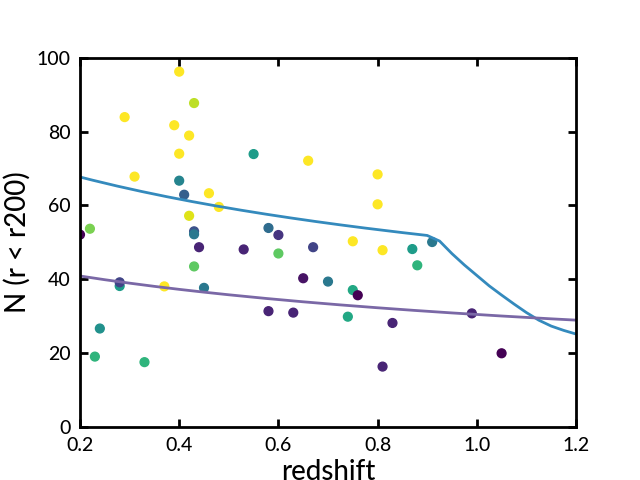

In [9]:
plt.plot(zs, (LF * V200.value + 1) * fr)
ax = plt.gca()
#ax.set_yticks(np.arange(0, 75, 10))
plt.xlim(0.2, 4)
plt.ylim(0, 100)
plt.xlabel('redshift')
plt.ylabel('N (r < r200)')
plt.grid()

# Add clusters from the Hennig paper.

In [10]:
import pandas as pd
df = pd.read_csv('../hennig/tbl.tex', sep='&', header=None, engine='python', comment='%', dtype='object')
for i in range(len(df.columns)):
    df[i] = df[i].map(lambda x: x.replace('$', ''))
    df[i] = df[i].map(lambda x: x.strip())

df.columns = ['Cluster', 'M200', 'z', 'cg', 'N200', 'cg,rs', 'N200,rs', 'cg,nrs', 'N200,nrs']
for c in df.columns:                                                             
    df.loc[df.loc[:, c].str.strip() == "-", c] = np.nan

for i in range(1, 2*len(df.columns), 2 ):
    try:
        df.insert(i+1, f'{df.columns[i]}_err', np.nan)
    except IndexError:
        pass    
    
df = df.astype('object')
for i, row in df.iterrows():
    for j in range(1, len(df.columns), 2):
        col = df.columns[j]
        col_err = df.columns[j + 1]
        try:
            # the error array is [plus, minus]
            df.at[i, col_err] = [float(row[col].split('^')[1][2:7].rstrip('}')), 
                                 abs(float(row[col].split('^')[1][10:].rstrip('}')))]
            df.at[i, col] = float(row[col].split('^')[0])
        except IndexError:
            df.at[i, col_err] = float(row[col].split('\pm')[-1])
            df.at[i, col] = float(row[col].split('\pm')[0])
        except AttributeError:
            continue

# make numeric columns numeric
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')

In [11]:
### recalculate things ###
##########################

# So now we are going to calculate the volumes as a function of z
M200 = 6e14 * u.solMass
V200 = M200/ (200 * rho_crit(zs, cosmo))

# The Hennig paper gives their depths in table 2. 
# I am just going to do everything in the i band.

# calculate the abs mag of our limiting magnitude as a function of z
mstar = model.get_apparent_mags(zf, filters='i', zs=zs)
mlim = mstar - 2.5 * np.log10(0.4) 
Mlim = mlim - cosmo.distmod(zs).value - model.get_kcorrects(zf, filters='i', zs=zs)

#Mlim = model.get_absolute_mags(zf, filters='i', zs=zs) + 2

# Calculate the M_star values
Mstar = model.get_absolute_mags(zf, filters='i', zs=zs)

# Here are the Schechter function stuff from Liu et al.
phi_star = 3.6 * cosmo.efunc(zs)**2
alpha = -1.05 * (1 + zs)**(-2/3)
fr = 0.8*(1 + zs)**(-1/2)

In [12]:
LF = []
for phi, a, M_star, M_lim in zip(phi_star, alpha, Mstar, Mlim):
    y, err = quad(schechterM, -30, M_lim, args=(phi, a, M_star))
    LF.append(y)

In [13]:
# plot the model
plt.plot(zs, (LF * V200.value + 1) * fr)
ax = plt.gca()
#ax.set_yticks(np.arange(0, 75, 10))
plt.xlim(0.2, 1.2)
plt.ylim(0, 100)
plt.xlabel('redshift')
plt.ylabel('N (r < r200)')
plt.grid()

# add the clusters
for i, row in df.iterrows():
    if (row.M200 + row.M200_err[0] > 6) and (6 > row.M200 - row.M200_err[1]):
        if np.isnan(row['N200,rs']):
            continue
        #ax.errorbar(row.z, row['N200,rs'], yerr=np.array(row['N200,rs_err'][::-1])[:, np.newaxis], fmt='o', zorder=0, c=row.M200)
        #ax.scatter(row.z, row['N200,rs'], fmt='o', zorder=0, c=)
        
ax.scatter(df.z, df['N200,rs'], c=df.M200, cmap='viridis', vmin=5, vmax=7, s=40, zorder=1)
#df.plot.scatter('z', 'N200,rs', ax=ax, c='M200', colormap='viridis',vmin=5, vmax=7, s=40)
#plt.axhline(6)

# Test Area Below...

In [ ]:
#df.loc[(df.M200 + df.M200_err[0] > 6) & (6 > df.M200 - df.M200_err[1])]
df.M200_err.data

In [ ]:
# calculate the abs mag of our limiting magnitude as a function of z
mlim_arr = [19.5, 21.2]
for mlim in mlim_arr:
    Mlim = mlim - cosmo.distmod(zs).value - model.get_kcorrects(zf, filters='i', zs=zs)

    # Calculate the M_star values
    Mstar = model.get_absolute_mags(zf, filters='i', zs=zs)

    # Here are the Schechter function stuff from Liu et al.
    phi_star = 3.6 * cosmo.efunc(zs)**2
    alpha = -1.05 * (1 + zs)**(-2/3)
    fr = 0.8*(1 + zs)**(-1/2)

    LF = []
    for phi, a, M_star, M_lim in zip(phi_star, alpha, Mstar, Mlim):
        y, err = quad(schechterM, -np.inf, M_lim, args=(phi, a, M_star))
        LF.append(y)
        
    plt.plot(zs, (LF * V200.value + 1) * fr)

ax = plt.gca()
ax.set_yticks(np.arange(0, 75, 10))
plt.xlim(0.2, 1)
plt.ylim(0, 75)
plt.xlabel('redshift')
plt.ylabel('N (r < r200)')
plt.grid()

In [18]:
df.loc[(df.M200 + df.M200_err[0] > 6) and (6 > df.M200 - df.M200_err[1])]

ValueError: operands could not be broadcast together with shapes (74,) (2,) 

In [ ]:
2.5 * np.log10(0.4)